In [5]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib, vc_protocols
import mod_trace
from kylie2017IKr import Kylie2017IKr

import simulator_myokit
import vc_protocols_for_myokit

In [19]:
sys.path.append(f'../../../../Dataset/herg25oc1_real_data')
from getdata import get_dataset, get_times

In [83]:
def MSE(y, y_pred, axis=1):
	return np.mean(np.square(y - y_pred), axis=axis)

In [84]:
dir_path = './Results'
try:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print('"%s" has been created.'%(dir_path))
    else:
        print("The folder already exists.")
except OSError:
    print('Error: create_folder(). : ' + dir_path)

The folder already exists.


In [74]:
# for i in range(5):
# xs, ys = get_dataset(file_numbers=range(1, 3), multi=True, use_torch=True)

# xs, ys = get_dataset(file_numbers=range(1, 31), window=10, step_size=5, multi=False, use_torch=False, get_raw=False)

cell_to_remove=['A04', 'A15', 'E05', 'E22', 'G10', 'G22', 'H08', 'I10', 'I12', 'I16', 'L08', 'P15', 'P18' ] # M24
cell_to_remove=[]

xs, ys, cells = get_dataset(cell_to_remove=cell_to_remove, scale=1, multi=True, torch_tensor=False)  # <-- fast
times = get_times(scale=1)

The number of full cells : 211
The number of removed Cells : 0
The number of cells : 211


In [75]:
test_index = 1
test_current = xs[test_index]
test_params = ys[test_index]
test_cell = cells[test_index]
print(f"Test cell : {test_cell}")

Test cell : A04


In [76]:
dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())

In [77]:
start_time = time.time()

m_myokit, protocol, script = myokit.load("../../../mmt-model-files/kylie-2017-IKr.mmt" )
protocol = vc_protocols.leak_staircase()

# model, protocol, _ = vc_protocols_for_myokit.leak_staircase(model)
sim_myokit = simulator_myokit.Simulator(m_myokit, protocol, max_step=1.0, abs_tol=1e-08, rel_tol=1e-10, vhold=-80e-3 )  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "kylie-2017-IKr"

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.774343729019165 seconds ---


In [92]:
start_time = time.time()

parameters = { 
    'ikr.g' : test_params[0],
    'ikr.p1' : test_params[1],
    'ikr.p2' : test_params[2],
    'ikr.p3' : test_params[3],
    'ikr.p4' : test_params[4],
    'ikr.p5' : test_params[5],
    'ikr.p6' : test_params[6],
    'ikr.p7' : test_params[7],
    'ikr.p8' : test_params[8],
}

sim_myokit.set_simulation_params( parameters)
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
sol_real_sim = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent1 = {
    'O': sol_real_sim['ikr.open']*sol_real_sim['ikr.active'],
    'I': sol_real_sim['ikr.open']*(1-sol_real_sim['ikr.active']),
    'C': (1-sol_real_sim['ikr.open'])*sol_real_sim['ikr.active'],
    'IC': (1-sol_real_sim['ikr.open'])*(1-sol_real_sim['ikr.active']),    
}

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.0399444103240967 seconds ---


In [93]:
model_params_dir = "./Results-herg25oc1-staircaseramp-solution-CMAES-542811797"

In [94]:
start_time = time.time()

file = os.path.join(model_params_dir, f"{test_cell}_prior_p72_u50_ui11_nrFalse.txt")
f = open(file, mode='r')
info = f.readlines()
sol1_params = []
for i in range(6, 15):
    sol1_params.append(float(info[i]))
sol1_params = np.array(sol1_params)
f.close() 

parameters = { 
    'ikr.g' : sol1_params[0],
    'ikr.p1' : sol1_params[1],
    'ikr.p2' : sol1_params[2],
    'ikr.p3' : sol1_params[3],
    'ikr.p4' : sol1_params[4],
    'ikr.p5' : sol1_params[5],
    'ikr.p6' : sol1_params[6],
    'ikr.p7' : sol1_params[7],
    'ikr.p8' : sol1_params[8],
}

sim_myokit.set_simulation_params( parameters)
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
sol1 = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent1 = {
    'O': sol1['ikr.open']*sol1['ikr.active'],
    'I': sol1['ikr.open']*(1-sol1['ikr.active']),
    'C': (1-sol1['ikr.open'])*sol1['ikr.active'],
    'IC': (1-sol1['ikr.open'])*(1-sol1['ikr.active']),    
}

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.0800387859344482 seconds ---


In [95]:
start_time = time.time()

file = os.path.join(model_params_dir, f"{test_cell}_prior_p72_u50_ui11_nrTrue.txt")
f = open(file, mode='r')
info = f.readlines()
sol2_params = []
for i in range(6, 15):
    sol2_params.append(float(info[i]))
sol2_params = np.array(sol2_params)
f.close() 

parameters = { 
    'ikr.g' : sol2_params[0],
    'ikr.p1' : sol2_params[1],
    'ikr.p2' : sol2_params[2],
    'ikr.p3' : sol2_params[3],
    'ikr.p4' : sol2_params[4],
    'ikr.p5' : sol2_params[5],
    'ikr.p6' : sol2_params[6],
    'ikr.p7' : sol2_params[7],
    'ikr.p8' : sol2_params[8],
}

sim_myokit.set_simulation_params( parameters)
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
sol2 = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent2 = {
    'O': sol2['ikr.open']*sol2['ikr.active'],
    'I': sol2['ikr.open']*(1-sol2['ikr.active']),
    'C': (1-sol2['ikr.open'])*sol2['ikr.active'],
    'IC': (1-sol2['ikr.open'])*(1-sol2['ikr.active']),    
}

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.0319397449493408 seconds ---


In [96]:
print(test_params)
print(sol1_params)
print(sol2_params)

[2.15551690e+05 2.08195282e-01 8.31542757e+01 4.05221401e-03
 6.71445986e+01 2.36848494e+02 3.36608156e-04 2.43929800e+00
 1.98091312e+01]
[1.831607e+05 2.074193e-01 8.337661e+01 4.138080e-03 6.693504e+01
 2.371023e+02 1.000994e-04 2.879801e+00 1.990638e+01]
[1.912541e+05 2.091615e-01 8.279702e+01 3.854588e-03 6.748639e+01
 2.430501e+02 1.001387e-04 2.823735e+00 1.983351e+01]


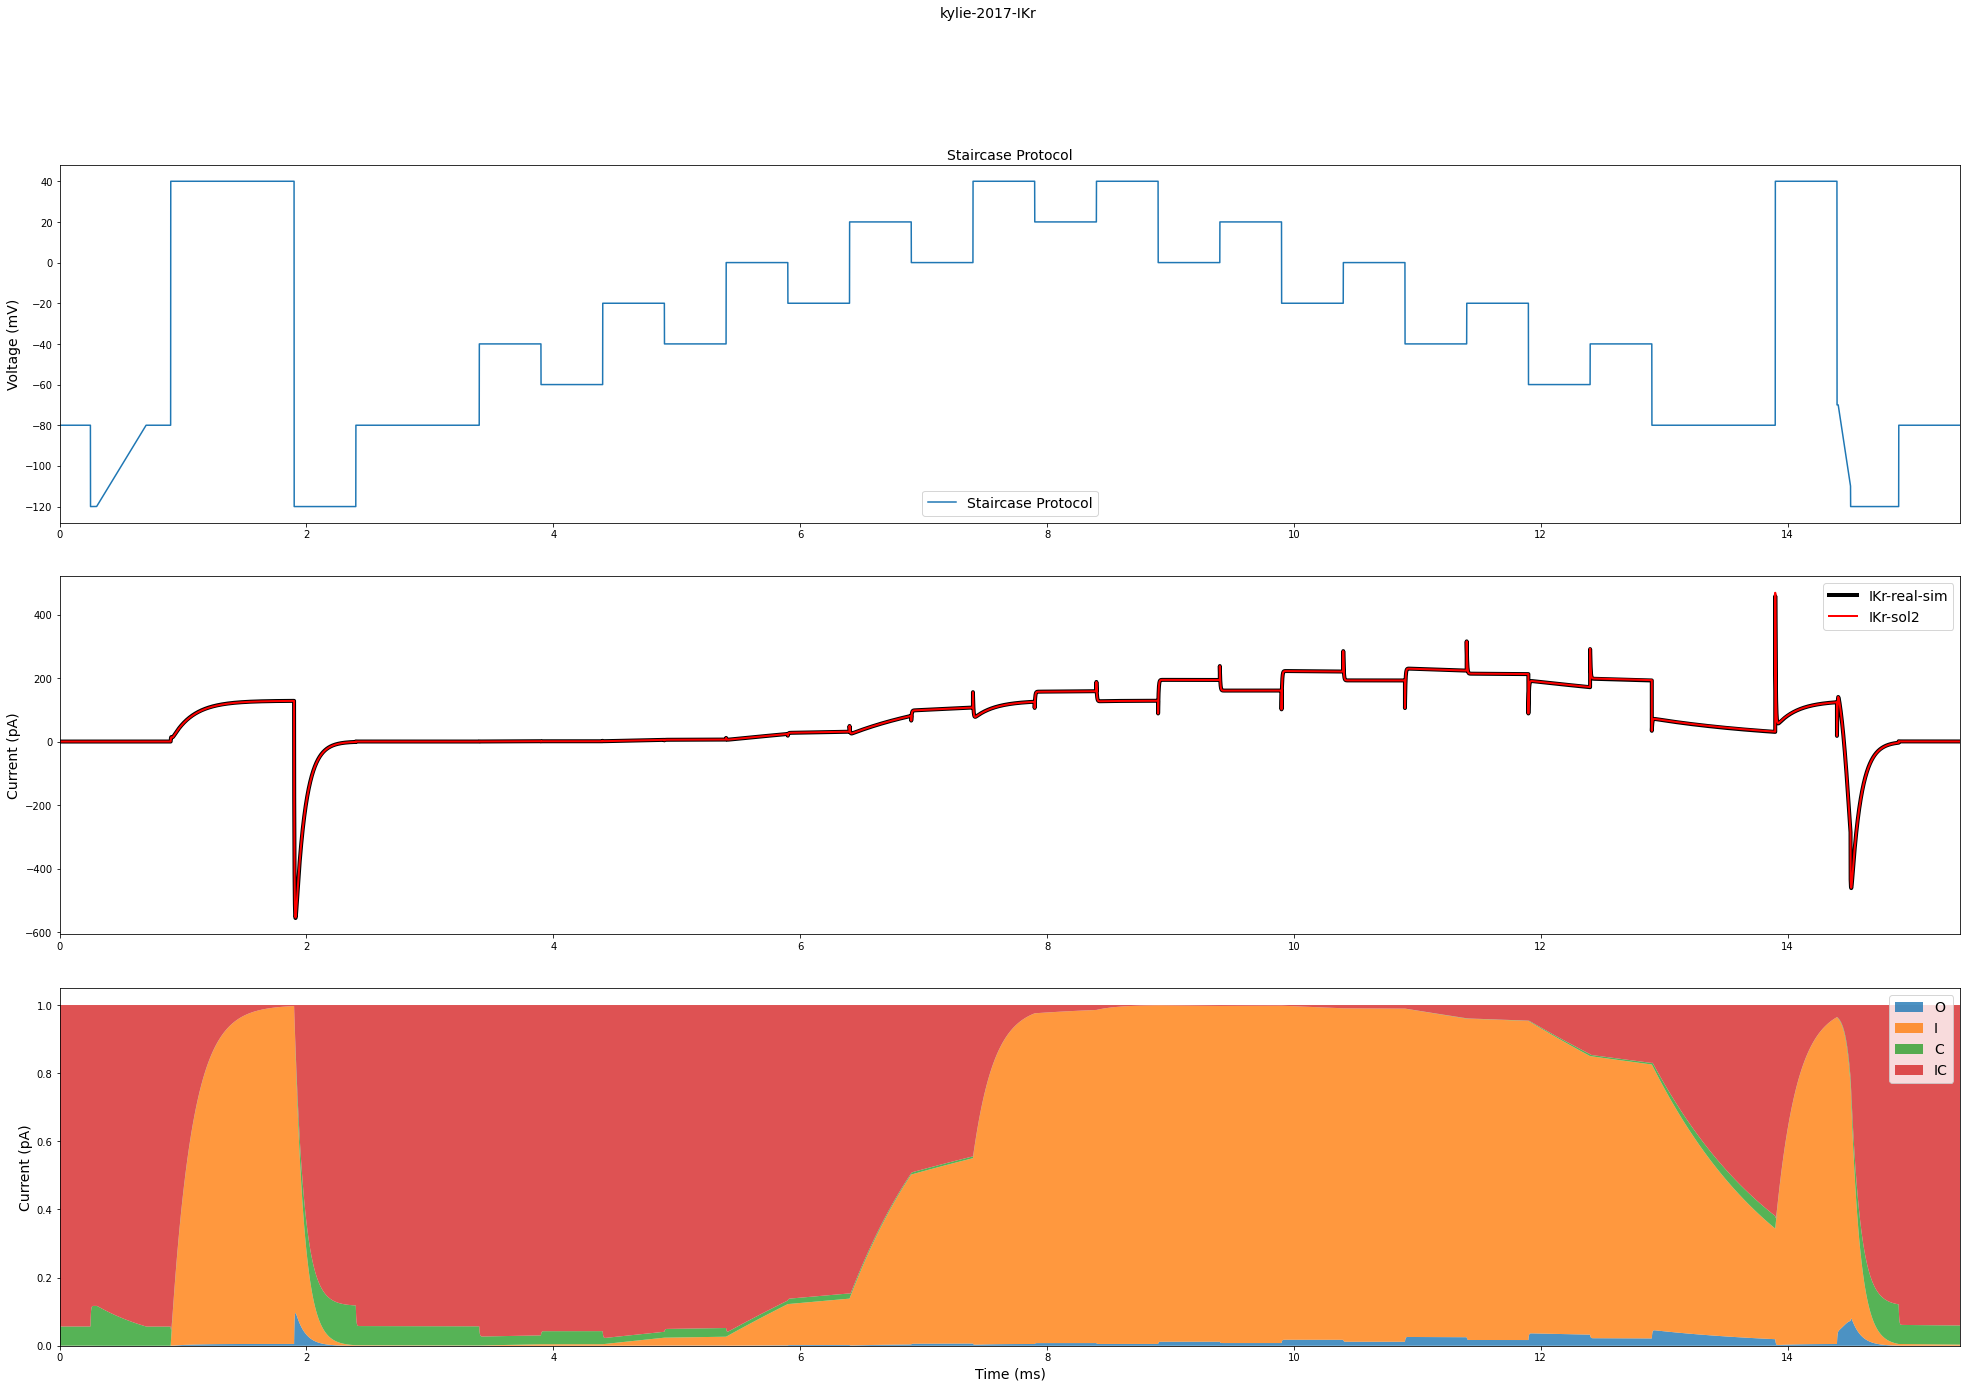

Complete


In [98]:
fig, axes = plt.subplots(3, figsize=(30, 20))
fig.suptitle(sim_myokit.name, fontsize=14)
axes[0].set_title("Staircase Protocol", fontsize=14)
axes[0].set_xlim(0, t_eval[-1])
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot( t_eval, d_myokit['membrane.V']*1000, label="Staircase Protocol")
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(Gs[0], Gs[1], Gs[2], Gs[3], Gs[4], Gs[5], Gs[6], Gs[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# axes[0].text(0.67, 0.60, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axes[0].legend(fontsize=14)
axes[0].xaxis.set_visible(True)

axes[1].set_xlim(0, t_eval[-1])
axes[1].set_ylabel("Current (pA)", fontsize=14)
# axes[1].plot(t_eval, test_current, label="IKr-sol1", linewidth=4, color='k')
axes[1].plot(t_eval, sol_real_sim['ikr.IKr'], label="IKr-real-sim", linewidth=4, color='k')
# axes[1].plot(t_eval, sol1['ikr.IKr'], label="IKr-sol1", linewidth=5, color='y')
axes[1].plot(t_eval, sol2['ikr.IKr'], label="IKr-sol2", linewidth=2, color='r')
axes[1].legend(fontsize=14)
axes[1].xaxis.set_visible(True)

axes[2].set_xlim(0, t_eval[-1])
axes[2].set_xlabel("Time (ms)", fontsize=14)
axes[2].set_ylabel("Current (pA)", fontsize=14)
axes[2].stackplot(t_eval, population_by_continent1.values(), labels=population_by_continent.keys(), alpha=0.8)
axes[2].legend(fontsize=14)
axes[2].xaxis.set_visible(True)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.87, wspace=0.5, hspace=0.15)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
# fig.savefig(os.path.join('Results', 'Kylie2017IKr_VC.jpg'), dpi=100)
print("Complete")